In [ ]:
import jax
import neos.makers as makers
import neos.cls as cls
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())

In [ ]:
# regression net
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid 
)

In [ ]:
bins = np.linspace(0,1,4)
centers   = bins[:-1]  + np.diff(bins)/2.
bandwidth = .8 * 1/(len(bins)-1)

hmaker = makers.kde_bins_from_nn_histosys(predict,bins=bins,bandwidth=bandwidth)
nnm = makers.nn_histosys(hmaker)
loss = cls.cls_maker(nnm, solver_kwargs=dict(pdf_transform=True))
bandwidth

0.26666666666666666

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(13), (-1, 2))
jax.grad(loss)(network, 1.0)

[(DeviceArray([[-1.4099019e-04, -1.1353670e-04,  3.5842124e-05, ...,
                -5.5608398e-05,  1.3211224e-04, -1.0256166e-04],
               [ 2.4770791e-04,  3.8655697e-05, -1.7657612e-05, ...,
                 1.0260434e-05, -1.9944536e-04, -4.2699476e-06]],            dtype=float32),
  DeviceArray([-8.9781264e-05, -4.7815578e-05, -3.9236125e-05, ...,
                5.1368836e-05,  8.7203072e-05, -4.6756573e-05],            dtype=float32)),
 (),
 (DeviceArray([[-1.5714439e-06,  7.4928991e-08, -4.2954351e-10, ...,
                -2.7303329e-07,  3.9283182e-06,  1.2574671e-06],
               [ 2.0880186e-07,  4.5355327e-07,  5.2989000e-09, ...,
                 0.0000000e+00,  2.8177158e-07, -1.5085504e-11],
               [-8.2368882e-07, -1.4185782e-08, -4.8139370e-10, ...,
                 1.0981012e-09, -8.2328881e-07,  7.9006350e-07],
               ...,
               [-6.1103640e-07, -2.5124691e-06, -3.2183237e-08, ...,
                 1.2991454e-07, -3.6418332e-06, 

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(1e-3)

#@jax.jit
def update_and_value(i, opt_state, mu):
    net = opt_params(opt_state)
    value, grad = jax.value_and_grad(loss)(net, mu)
    return opt_update(i, grad, state), value, net

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i,state,1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
def plot(axarr, network, metrics, hm, maxN):
    ax = axarr[0]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    levels = bins
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    ax.scatter(hm.sig[:, 0], hm.sig[:, 1], alpha=0.3, c="C9", label="sig")
    ax.scatter(hm.bkg_up[:, 0], hm.bkg_up[:, 1], alpha=0.2, c="gold", label="bkg1")
    ax.scatter(hm.bkg_down[:, 0], hm.bkg_down[:, 1], alpha=0.2, c="gold", label="bkg2")
    ax.scatter(hm.bkg_nom[:, 0], hm.bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg2")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.6)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, bup, bdown = hm(network)
    
    bin_width = 1/(len(bins)-1)
    ax.bar(centers, b, color="C1", label="bkg",width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", label="sig",width=bin_width)
    
    bunc = np.asarray([[x,y] if x>y else [y,x] for x,y in zip(bup,bdown)])
    plot_unc = []
    for unc, be in zip(bunc,b):
        if all(unc > be):
            plot_unc.append([max(unc),be])
        elif all(unc < be):
            plot_unc.append([be, min(unc)])
        else:
            plot_unc.append(unc)
    
    plot_unc = np.asarray(plot_unc)
    b_up, b_down = plot_unc[:,0], plot_unc[:,1]
    
    ax.bar(centers, b_up-b, bottom=b, alpha=0.4, color="black", label="bkg error",width=bin_width)
    ax.bar(centers, b-b_down, bottom=b_down, alpha=0.4, color="black", label="bkg error",width=bin_width)
    
    
    ax.set_ylim(0, 50)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

### Let's run it!!

epoch 0: CLs = 0.06834128512974225, took 1.2285470962524414s
[[27.44054774 24.91447503]
 [46.73521329 46.31105763]
 [22.22839792 19.85710072]] [26.27410103 46.48565351 20.95941375]


KeyboardInterrupt: 

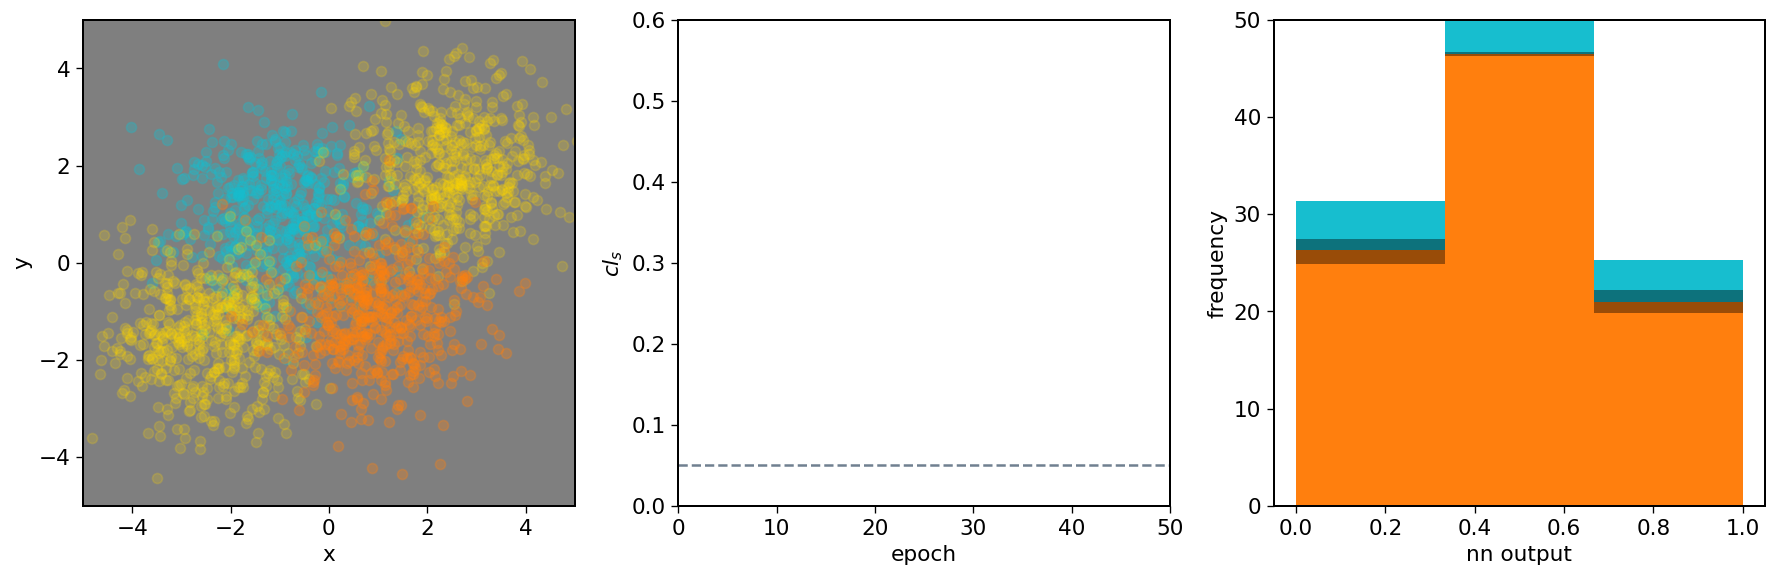

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)
fig.set_size_inches(15, 5)
camera = Camera(fig)

maxN = 50 # make me bigger for better results!

animate = True # animations fail tests

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            #HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)

In [ ]:
x= [2,4]

In [ ]:
min(x)

2